In [1]:
%matplotlib inline

In [2]:
from io import StringIO
import math
import itertools
from datetime import datetime , timedelta
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import random
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from scipy.stats.contingency import margins
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import probscale

#sklearn imports
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, median_absolute_error,mean_squared_error,r2_score
from sklearn.model_selection import GridSearchCV 

#Statismodel import
from statsmodels.stats.stattools import durbin_watson
import scipy.stats as stats
from statsmodels.tsa.stattools import acf, pacf, adfuller
import statsmodels.api as sm

# Random forest regressor  imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE

In [3]:
pd.set_option('display.max_colwidth', 0)
sns.set(color_codes=True)
sns.set_style('darkgrid')
register_matplotlib_converters() 

## Short term weather forecast

### Comparison of Vector Autoregression Model (VAR)<br> and Random Forest Regressor<br><br>


### Abstract
Weather forecasting is the application of science and technology to predict the conditions of the atmosphere for a given location and time. 
The purpose of this work is to evaluate the possibility of using regressive  algorithms as a way to predict weather elements such as temperature, humidity, atmospheric pressure etc. I will explore the predictive ability and will compare the results of Vector Autoregression Model (VAR) and Random Forest Regressor passing the same tests and validation data.<br><br>

#### Data
A dataset for historical weather data for city of Basel Switzerland was downloaded from [Meteoblue](https://www.meteoblue.com/) website. The forecast will include `Temperature`, `Relative Humidity`,`Atmospheric Pressure` and `Wind Speed`


#### Forecast settings
In this section I have set the starting date of the forecast as well as the length of the forecast period and the length of the training set.<br>
These dates should be fixed for both of the models. The idea is to have the same testing data for training both of the models.

In [4]:
# Starting data
start_forecast_date = '2020-08-18' 

#length of the forecast
forecast_length = 15

#training set length
train_set_length = 60

date_format = "%Y-%m-%d"
start_fd = datetime.strptime(start_forecast_date, date_format)
end_fd = start_fd + timedelta(days = forecast_length-1)
end_forecast_date = datetime.strftime(end_fd, date_format)
start_train_date = datetime.strftime(start_fd - timedelta(days = train_set_length) , date_format)
end_train_date = datetime.strftime(start_fd - timedelta(days = 1) , date_format)
start_rfe_train_data = datetime.strftime(start_fd - timedelta(days = train_set_length+10), date_format)
print("Final trainig set from date: {} to data: {}".format(start_train_date,end_train_date))
print("Final validation set from date: {} to data: {}".format(start_forecast_date,end_forecast_date))

Final trainig set from date: 2020-06-19 to data: 2020-08-17
Final validation set from date: 2020-08-18 to data: 2020-09-01


In [5]:
#Use skipinitialspace to remove the white spaces (empty strings) and make those cells Nan
weather_data = pd.read_csv('data/basel_data.csv',skipinitialspace=True)
weather_data.columns = ['timestamp', 'Min Temperature (C)', 'Max Temperature (C)',
        'Temperature (C)', 'Min Relative Humidity (%)', 'Max Relative Humidity (%)',
        'Relative Humidity (%)', 'Min Pressure (hPa)', 'Max Pressure (hPa)',
        'Pressure (hPa)', 'Precipitation (mm)', 'Snowfall Amount (cm)',
        'Cloud Cover(%)', 'Cloud Cover High (%)', 'Cloud Cover Medium (%)',
        'Cloud Cover Low (%)', 'Sunshine Duration (min)', 'Shortwave Radiation (W/m^2)',
        'Direct Shortwave Radiation (W/m^2)', 'Diffuse Shortwave Radiation (W/m^2)',
        'Min Wind Gust (km/h)', 'Max Wind Gust (km/h)', 'Mean Wind Gust (km/h)',
        'Min Wind Speed [10 m] (km/h)', 'Max Wind Speed [10 m] (km/h)', 'Mean Wind Speed [10 m] (km/h)',
        'Wind Direction Dominant 10 m (deg)', 'Min Wind Speed [80 m] (km/h)', 'Max Wind Speed [80 m] (km/h)',
        'Wind Speed (km/h)', 'Wind Direction (deg)']

#Setting the features of interest
working_columns = ['timestamp', 'Temperature (C)', 'Relative Humidity (%)','Pressure (hPa)',
                   'Wind Speed (km/h)']
                  
weather_data = weather_data[working_columns]
weather_data.head()

,timestamp,Temperature (C),Relative Humidity (%),Pressure (hPa),Wind Speed (km/h)
0,20080102T0000,-0.716971,73.500000,1018.27094,20.152584
1,20080103T0000,1.312195,79.291664,1007.71246,24.399324
2,20080104T0000,3.012196,80.000000,1010.79987,23.884330
3,20080105T0000,7.090530,70.583336,1012.06670,20.224419
4,20080106T0000,7.061361,90.250000,1013.62915,16.375706


Using the past temperature as far as 2008 might not be a good indicator for today’s weather data, as there have been other recent factors that should be taken into account, for example, the gradually rising temperature due to global warming.
Thus, to have a possibly better analysis and forecast result because of the understanding of recent influential factors, I would take only a subset of data from September 2015 to September 2020.

In [6]:
#Cleaning the date string from not needed parts
weather_data['date'] = weather_data['timestamp'].str.split('T').str[0]
weather_data = weather_data.reset_index()
weather_data = weather_data.drop('index', axis=1)
weather_data = weather_data.drop('timestamp', axis=1)

#Convert 'Date' column to contain datetime objects
weather_data['date'] = pd.to_datetime(weather_data['date'],format='%Y%m%d')

#Filtering the dataset to needed timerange  
period = ((weather_data['date'] >= '2015-09-28') &
          (weather_data['date'] <= '2020-09-01'))

working_data = weather_data.loc[period]

#Converting the dataset to time series
working_data = working_data.set_index('date')
working_data = working_data.sort_index()
working_data.head()

,Temperature (C),Relative Humidity (%),Pressure (hPa),Wind Speed (km/h)
date,,,,
2015-09-28,10.823029,66.791664,1029.4917,16.339367
2015-09-29,11.324280,62.125000,1027.3999,20.574327
2015-09-30,11.288029,65.208336,1026.6375,12.450026
2015-10-01,10.252195,69.000000,1025.4957,9.671327
2015-10-02,12.505112,72.083336,1022.0249,8.168427


A copy was created to ensure that the initial time series will be intact. It will be used for comparing the forecasts with the initial data.

In [7]:
#Keeping original data intact for comparing with the forecast
origin_set = working_data.copy()
origin_set = origin_set.drop(origin_set.index[0]) 

In [8]:
working_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature (C),1801.0,12.660249,7.103276,-6.038639,6.860113,12.198861,18.283028,30.425112
Relative Humidity (%),1801.0,68.932815,9.533208,33.625000,61.958332,69.333336,76.166664,91.166664
Pressure (hPa),1801.0,1017.608960,8.391094,984.695860,1013.125060,1017.391800,1022.570860,1047.095800
Wind Speed (km/h),1801.0,15.026785,8.896820,2.884306,8.901058,12.694715,18.420513,61.596590


Except for the temperature data frame shouldn't contain negative values in any other column. That is why those were made positive.

In [9]:
positive_val_columns = ['Relative Humidity (%)','Pressure (hPa)','Wind Speed (km/h)']
for col in positive_val_columns:
    working_data[col] = abs(working_data[col])

#### Exploratory analysis


In [10]:
def plot_feature_data(df):
    """Plotting data by chosen feature"""
    plt.figure(figsize=(10, 6))
    for col in df.columns:
        plt.plot(df[col], linewidth=0.8, label = col)
    plt.title('Weather in Basel from Sept 2016 to Sept 2020')
    plt.xlabel('Time')
    plt.ylabel('ammount')
    plt.legend(loc='best',bbox_to_anchor=(0.81, 0.51, 0.5, 0.5))
    plt.show()
    

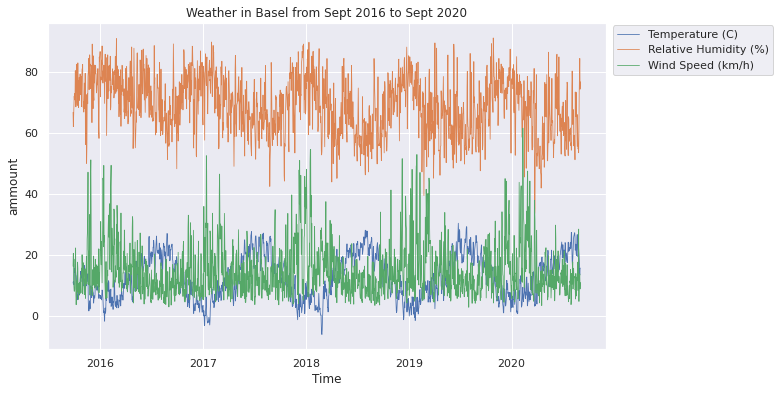

In [11]:
plot_feature_data(working_data[['Temperature (C)', 'Relative Humidity (%)',
                   'Wind Speed (km/h)']])

The plot above is noisy, because it contains all the daily data.


### Checks for Stationarity <br>

Stationarity is one of the most important properties of time series. It means that the parameters of the model (mean and standard deviation) don't depend on time. <br><br>
The methods, used to check for stationarity are as follows:<br>
- Seasonal decompose
- Augmented Dickey-Fuller (ADF) test



#### 1. Seasonal decompose <br>
A seasonal decompose of temperature column was made to check the seasonality and the trend.

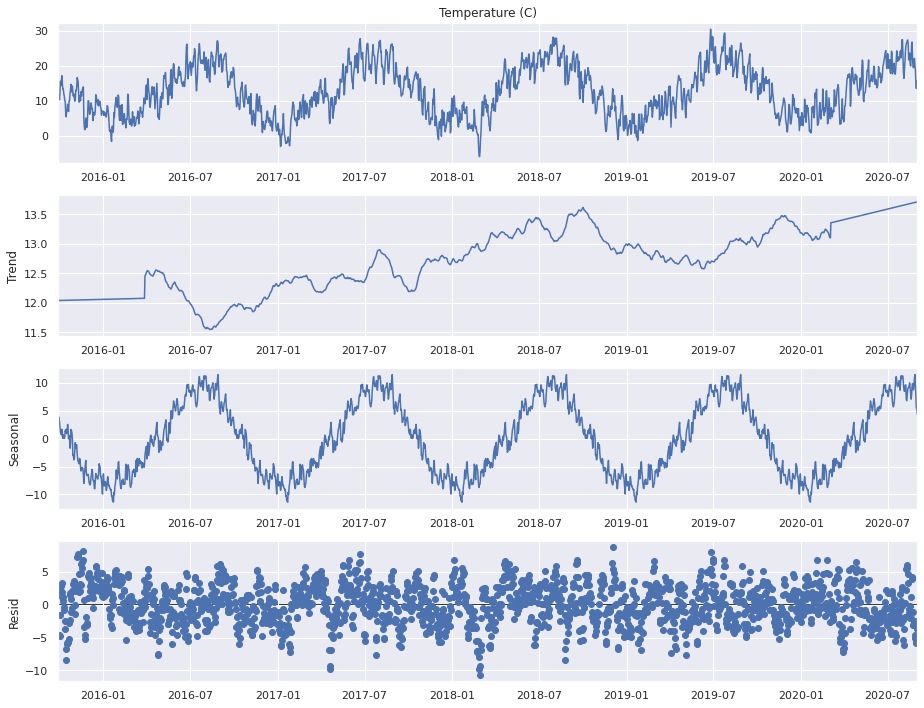

In [12]:
#Taking seasonal decompose plot
dec = sm.tsa.seasonal_decompose(working_data['Temperature (C)'], model='additive',
                                extrapolate_trend='freq', period=365)
#Plotting decompose elements
trend = dec.trend
seasonal = dec.seasonal
plt.rcParams.update({'figure.figsize': (13,10)})
dec.plot()
plt.show() 

Inspecting the graph, I noticed some considerable fluctuations of the rolling variance across time, which indicates violation of stationarity. 

#### 2. Augmented Dickey-Fuller test (ADF)

This is one of the statistical tests for checking stationarity. The null hypothesis is that the time series is non-stationary. 
ADF tests the null hypothesis that a unit root is present in time series sample. ADF statistic is a negative number and more negative it is the stronger the rejection of the hypothesis that there is a unit root.<br><br>
- <b>Null Hypotehsis (H0):</b> If accepted, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.<br><br>
- <b>Alternate Hypothesis (H1):</b> The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary.<br><br>
- <b>p-value > 0.05:</b> Accept H0, the data has a unit root and is non-stationary<br><br>
- <b>p-value ≤ 0.05:</b> Reject H0. the data does not have a unit root and is stationary

In [13]:
def adf_test(timeseries, col_names):
    """Performs Augmented Dickey-Fuller test for all the features then constructs a 
    dataframe with the results from the tests"""
    
    stationary_data = {'feature':[], 'Test statistics':[],'P-value':[], 
                   '99% confidence':[], '95% confidence':[], '90% confidence':[]}
    for col in col_names:
        dftest = adfuller(timeseries[col].dropna(), autolag='AIC')
        stationary_data['feature'].append(col)
        stationary_data['Test statistics'].append(dftest[0].round(3))
        stationary_data['P-value'].append(dftest[1])
        for k, v in dftest[4].items():
            perc = 100 - int(k[: -1])
            union = ''
            if v < dftest[0] :
                union = 'non '
            result = str(v.round(6)) + ' -> ' + union + 'stationary'
            if perc == 99:
                stationary_data['99% confidence'].append(result)
            elif perc == 95:
                stationary_data['95% confidence'].append(result)
            else:
                stationary_data['90% confidence'].append(result)
                
    return pd.DataFrame(data=stationary_data)           


In [14]:
# Multiple column ADF test for entire dataset
adf_test(working_data, working_data.columns)

,feature,Test statistics,P-value,99% confidence,95% confidence,90% confidence
0,Temperature (C),-2.696,7.477373e-02,-3.434017 -> non stationary,-2.86316 -> non stationary,-2.567632 -> stationary
1,Relative Humidity (%),-4.449,2.430849e-04,-3.434019 -> stationary,-2.863161 -> stationary,-2.567633 -> stationary
2,Pressure (hPa),-6.502,1.154937e-08,-3.434029 -> stationary,-2.863165 -> stationary,-2.567635 -> stationary
3,Wind Speed (km/h),-6.539,9.460565e-09,-3.434019 -> stationary,-2.863161 -> stationary,-2.567633 -> stationary


It looks like only the "Mean Temperature (C)" column is non stationary.<br>
The min value of Temperature column is near -6 deg. I shifted those values with +10 to be able to perform log on temperature values. After fitting the model I will revert this shift to get the real forecast values.

In [15]:
working_data['Temperature (C)'] = working_data['Temperature (C)'] + 10

### Making the time series stationary

There are two main reasons behind non-stationarity of a time series:

1. <b>Trend:</b> Changing of the time series mean over time.<br><br>
2. <b>Seasonality:</b> Variations, which occur regularly at the specific time. <br><br>

Applying differencing to the log of the series should make the above series stationary. Differencing is typically performed to get rid of the varying mean. 
The result of this differencing can be seen below:

In [16]:
#Differencing
df_norm = working_data.copy()

for col in df_norm.columns:
    df_norm[col] = np.log(working_data[col]).diff(1)

df_norm = df_norm.dropna()
df_norm.head()

,Temperature (C),Relative Humidity (%),Pressure (hPa),Wind Speed (km/h)
date,,,,
2015-09-29,0.023787,-0.072430,-0.002034,0.230467
2015-09-30,-0.001701,0.048439,-0.000742,-0.502321
2015-10-01,-0.049882,0.056519,-0.001113,-0.252557
2015-10-02,0.105479,0.043716,-0.003390,-0.168889
2015-10-03,0.125185,-0.016905,-0.005519,-0.006166


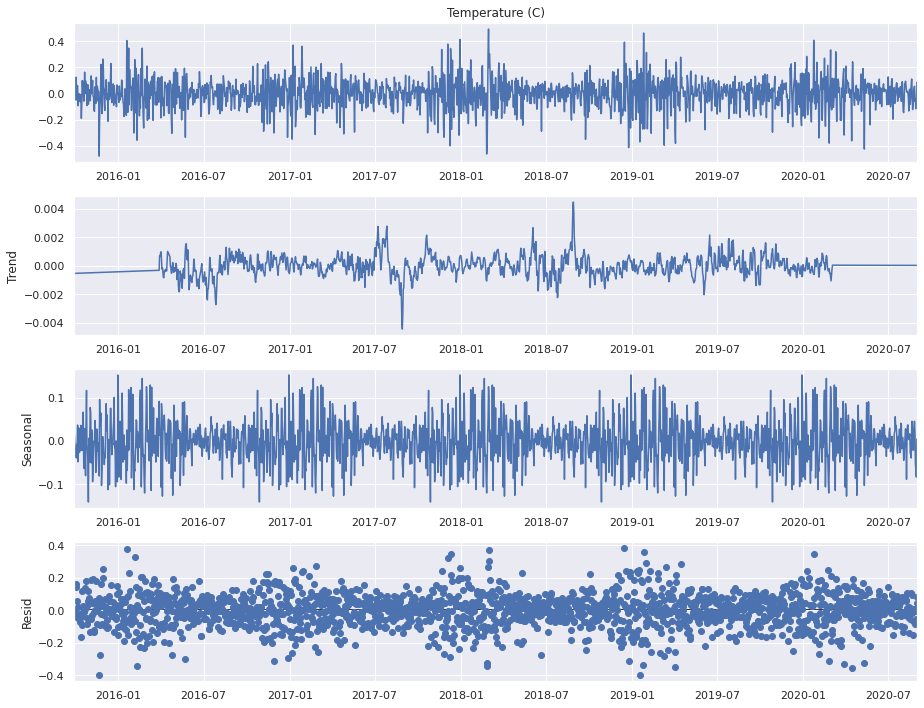

In [17]:
#Taking another seasonal decompose plot
dec_stationary = sm.tsa.seasonal_decompose(df_norm['Temperature (C)'], model='additive',
                                extrapolate_trend='freq', period=365)

dec_stationary.plot()
plt.show() 

In [18]:
# Multiple column ADF test after differencing
adf_test(df_norm, df_norm.columns)

,feature,Test statistics,P-value,99% confidence,95% confidence,90% confidence
0,Temperature (C),-14.740,2.576899e-27,-3.434027 -> stationary,-2.863164 -> stationary,-2.567635 -> stationary
1,Relative Humidity (%),-13.874,6.385930e-26,-3.434035 -> stationary,-2.863168 -> stationary,-2.567637 -> stationary
2,Pressure (hPa),-14.481,6.383243e-27,-3.434035 -> stationary,-2.863168 -> stationary,-2.567637 -> stationary
3,Wind Speed (km/h),-13.345,5.814345e-25,-3.434042 -> stationary,-2.863171 -> stationary,-2.567638 -> stationary


The transformed time series is with significantly less fluctuations in the moving average and standard deviation. However the Dickey Fuller test is much more confident to decide whether the transformed series is stationary.<br>
In our case the differencing did the job.

### Correlations
One of the assumptions of regression analysis is that the data has no autocorrelation. This can be frustrating because if one try to do a regression analysis on data with autocorrelation, then the analysis will be misleading.
The most compelling aspect of autocorrelation analysis is how it can help us uncover hidden patterns in the data and help one to select the correct forecasting methods. 
Additionally, analyzing the autocorrelation function (ACF) and partial autocorrelation function (PACF) in conjunction is necessary for selecting the appropriate model for the time series prediction.

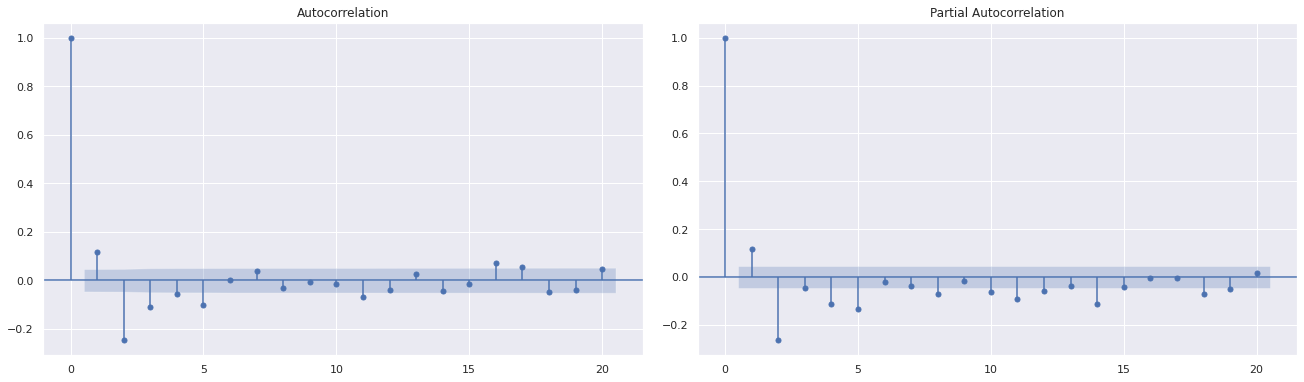

In [19]:
def create_correlation_dashboard(series):
    """Prepearing a dashboard with plots for autocorrelation ,
    partial autocorrelation and seasonal decompose plots"""
    
    fig = plt.figure(constrained_layout=True,figsize=(18,10))
    gs = GridSpec(2, 2, figure=fig)
    ax = fig.add_subplot(gs[0, :-1])
    sm.graphics.tsa.plot_acf(series,lags=20, alpha = .05, ax=ax)

    ax1 = fig.add_subplot(gs[0,-1])
    sm.graphics.tsa.plot_pacf(series,lags=20, alpha = .05, ax=ax1)
    plt.show()
    
create_correlation_dashboard(df_norm['Temperature (C)'])

### Splitting the data
For choosing the right model parameters I decided to have multiple data splits. Everyone of them should be as small as possible . Just enough to be able to train a model to predict weather for next 15 days. For every split we'll train a model and determine the correct `order` for the model. 
The training and validation data are based on the date and period lengths, which were set at the top.<br>
The idea is that I want to predict weather data for the next 15 days after initial date. Therefore the training set will be 60 days prior to initial date. This way I will have 24 periods each 75 days long. On every cycle a model should be trained with 60 days data and will try to predict the next 15 days.

Finally I will construct a data frame with calculated `Root mean squared errors` from the VAR model to evaluate its performance.

#### Choosing the right model order
For each period I created a new instance of the VAR (Vector autoregressive) model. 
Then I set the `lag_order`. Basically the order of the model means how many lags (data from previous day) the model should use to make the predictions.To figure out this parameter was the most difficult task I faced.<br>
The model has four different information criterion for selecting order. Our choice was to monitor AIC and BIC for every one of them.


In [20]:
# Lists needed for the order frame
periods, aics, bics  = [], [], []
date_format = '%Y-%m-%d'
date = df_norm.index[0]

def construct_order_frame(model_sel):
    """Processing and preparing data for orders dataframe"""
    df_m_sel = pd.read_csv(model_sel, header = [1])
    df_m_sel = df_m_sel.reset_index()
    new_columns = []
    for c in df_m_sel.columns:
        new_columns.append(c.strip())
        
    df_m_sel.columns = new_columns
    aics.append(df_m_sel[df_m_sel.AIC.str.contains('\*')].index[0])
    bics.append(df_m_sel[df_m_sel.BIC.str.contains('\*')].index[0])
    
    
def calculate_date_elements():
    """Creating the renage start and end dates for the test and valid periods"""
    start_t_date = datetime.strftime(date, date_format)
    end_t_date = datetime.strftime((date + timedelta(days = 59)), date_format)
    start_v_date = datetime.strftime((date + timedelta(days = 60)), date_format)
    end_v_date = datetime.strftime((date + timedelta(days = 74)), date_format)
    
    return start_t_date, end_t_date, start_v_date, end_v_date

In [21]:

"""Splitting the data on 23 time periods with equal length (75 days)"""
for i in range(24):
    start_t_date, end_t_date, start_v_date, end_v_date = calculate_date_elements()
    #Constructing train and validation set
    train_set = df_norm[start_t_date : end_t_date]
    valid_set = origin_set[start_v_date : end_v_date]
    
    #Setting initial date to be ready to the begining of the next test priod
    date = date + timedelta(days = 75)
    periods.append("{} - {}".format(start_v_date,end_v_date))

    #Initializing the VAR model
    model = sm.tsa.VAR(train_set, freq='D')
    model_sel = StringIO(model.select_order(maxlags=7).summary().as_csv())
    construct_order_frame(model_sel)

df_orders = pd.DataFrame(data={'Validation Period':periods, 'AIC':aics, 'BIC':bics})
df_orders 

,Validation Period,AIC,BIC
0,2015-11-28 - 2015-12-12,5,0
1,2016-02-11 - 2016-02-25,0,0
2,2016-04-26 - 2016-05-10,7,0
3,2016-07-10 - 2016-07-24,2,1
4,2016-09-23 - 2016-10-07,7,0
5,2016-12-07 - 2016-12-21,2,0
6,2017-02-20 - 2017-03-06,6,0
7,2017-05-06 - 2017-05-20,7,0
8,2017-07-20 - 2017-08-03,1,1
9,2017-10-03 - 2017-10-17,0,0


The time period that I chose to work with, was N 23 - AIC:5 and BIC:0.
So I had to choose which information criteria to use for our forecasts. 
- AIC tries to select the model that most adequately describes an unknown, high dimensional reality. 
- BIC tries to find the TRUE model among the set of candidates.<br>

After I received these huge differences between both of the criteria ,I decided to take the average. So I tried with order 2 and 3.

 ### The chosen model order
 After these tests and even more experiments, I put the `order` to 4. The decision was made because of both, better residual distributions and avoiding autocorrelation between the residuals.<br>
 Then i decided to make Augmented Dickey-Fuller test only on the training set. As I expected it was stationary.

In [22]:
#Setting the final training set
training_set = df_norm[start_train_date : end_train_date]
#
adf_test(training_set, training_set.columns)

,feature,Test statistics,P-value,99% confidence,95% confidence,90% confidence
0,Temperature (C),-7.239,1.901616e-10,-3.548494 -> stationary,-2.912837 -> stationary,-2.594129 -> stationary
1,Relative Humidity (%),-6.947,9.913308e-10,-3.55067 -> stationary,-2.913766 -> stationary,-2.594624 -> stationary
2,Pressure (hPa),-6.797,2.285930e-09,-3.55067 -> stationary,-2.913766 -> stationary,-2.594624 -> stationary
3,Wind Speed (km/h),-5.606,1.230904e-06,-3.555273 -> stationary,-2.915731 -> stationary,-2.59567 -> stationary


In [23]:
model = sm.tsa.VAR(training_set,freq='D')

#Setting the chosen order
lag_order = 4
model_result = model.fit(lag_order)

### Evaluation
Multiple tests were performed to evaluate the model. 
- Test for normality of standardized residuals
- Test for no serial correlation of standardized residuals

Both of those failed to reject the hypothesis, which means that the residuals are normaly distributed and there isn't autocorrelation between the residuals.

In [24]:
#Test for normality of standardized residuals
model_result.test_normality().summary()

Test statistic,Critical value,p-value,df
9.662,15.51,0.290,8


In [25]:
#Portmanteau-test for residual autocorrelation.
model_result.test_whiteness().summary()

Test statistic,Critical value,p-value,df
116.9,119.9,0.073,96


#### Durbin-Watson statistic
The null hypothesis of the test is that there is no serial correlation in the residuals. The Durbin-Watson test statistic is defined as:

$$\frac{\sum^T_{t=2}((e_t-e_{t-1})^2)}{\sum^T_{t=1}e^2_t} $$

The test statistic is approximately equal to $2(1-r)$ where r is the sample autocorrelation of the residuals. Thus, for r == 0, indicating no serial correlation, the test statistic equals 2. This statistic will always be between 0 and 4. The closer to 0 the statistic, the more evidence for positive serial correlation. The closer to 4, the more evidence for negative serial correlation.

In [26]:
#Prforming Durbin-Whatson statistics
out = durbin_watson(model_result.resid)
for col, val in zip(df_norm.columns, out):
    print(col, ':', round(val, 2))

Temperature (C) : 2.01
Relative Humidity (%) : 2.34
Pressure (hPa) : 2.09
Wind Speed (km/h) : 1.93


"A rule of thumb is that test statistic values in the range of 1.5 to 2.5 are relatively normal. Any value outside this range could be a cause for concern." The cite is taken from [investopedia.com](https://www.investopedia.com/terms/d/durbin-watson-statistic.asp).<br> 
The residuals from the current model falls into that range , so I can continue with the forecasting process.
#### Granger causality test
Finally a Granger causality test was performed.
The Granger causality test is a statistical hypothesis test for determining whether one time series is useful in forecasting another.No causality between the features was found.

In [27]:
features = df_norm.columns

#Granger causality test
for f in features:
    feat = features.copy().drop(f)
    w = model_result.test_causality(caused=feat, causing = f)
    print(w.summary())

Granger causality F-test. H_0: Temperature (C) does not Granger-cause [Relative Humidity (%), Pressure (hPa), Wind Speed (km/h)]. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         2.242          1.815   0.012 (12, 156)
-----------------------------------------------
Granger causality F-test. H_0: Relative Humidity (%) does not Granger-cause [Temperature (C), Pressure (hPa), Wind Speed (km/h)]. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         1.483          1.815   0.136 (12, 156)
-----------------------------------------------
Granger causality F-test. H_0: Pressure (hPa) does not Granger-cause [Temperature (C), Relative Humidity (%), Wind Speed (km/h)]. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------

### Forecast
Here was performed a forecast for wanted 15 days period.
Then data transformation was reverted to original scale.<br>
I had to pass chosen count of lags before initial date and the length of the forecast period.
And finally a comparison data frame was constructed  to visualize the predicted and actual data side by side.

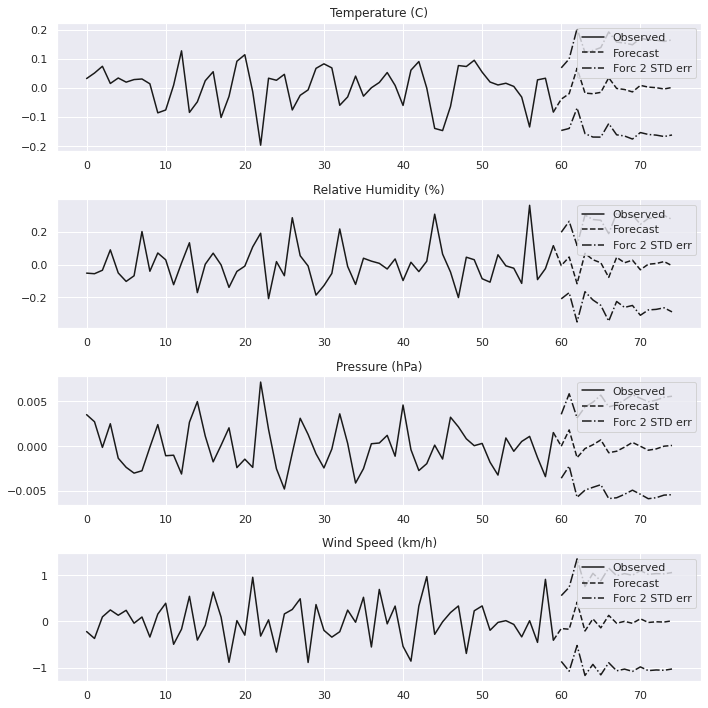

In [28]:
model_result.plot_forecast(15)
plt.tight_layout()
plt.show()

In [29]:
#Creating the final validation set
validation_set = df_norm[start_forecast_date: end_forecast_date]

#Perform forecast
forecast = model_result.forecast(training_set[lag_order:].values ,steps=forecast_length)
df_forecasted = pd.DataFrame(data = forecast, index = validation_set.index, columns = validation_set.columns)
df_forecasted.head()

,Temperature (C),Relative Humidity (%),Pressure (hPa),Wind Speed (km/h)
date,,,,
2020-08-18,-0.038896,-0.005919,-0.000006,-0.153249
2020-08-19,-0.020098,0.045955,0.001816,-0.168820
2020-08-20,0.067046,-0.116425,-0.001279,0.418500
2020-08-21,-0.017988,0.068142,-0.000264,-0.206446
2020-08-22,-0.020374,0.029398,0.000160,0.056664


In [30]:
def revert_transformation(df_f, start_date, end_date):
    """Revert back the differencing to get the forecast to original scale."""
    for col in df_f.columns:
        df_f[col+'_f'] = np.exp(df_f[col]) *\
            working_data[start_date:end_date][col]
        df_f = df_f.drop(columns = [col])
    
    #Reverting the temperature shift
    df_f['Temperature (C)_f']  = df_f['Temperature (C)_f'] - 10
    return df_f

In [31]:
#Reversing the data transformation
df_forecasted = revert_transformation(df_forecasted, start_forecast_date, end_forecast_date )

#### The  results

In [32]:
#Creating a comparisson DataFrame with observed and predicted values
df_comparisson = pd.DataFrame()
for col in origin_set.columns:
    df_comparisson[col] = origin_set[col][start_forecast_date:end_forecast_date]
    df_comparisson[col+'_f'] = df_forecasted[col+'_f']
df_comparisson.head()

,Temperature (C),Temperature (C)_f,Relative Humidity (%),Relative Humidity (%)_f,Pressure (hPa),Pressure (hPa)_f,Wind Speed (km/h),Wind Speed (km/h)_f
date,,,,,,,,
2020-08-18,19.861780,18.722578,67.291664,66.894521,1013.33760,1013.331915,6.568682,5.635380
2020-08-19,21.908030,21.273154,64.750000,67.795042,1011.17914,1013.016720,9.145569,7.724905
2020-08-20,25.671778,28.145440,59.125000,52.626983,1009.77094,1008.480463,12.773328,19.411384
2020-08-21,26.715948,26.061417,55.583332,59.502914,1012.22070,1011.953332,11.663785,9.488139
2020-08-22,22.474280,21.819330,66.000000,67.969085,1018.54584,1018.708805,16.417137,17.374266


Here I made a combined plot with the predicted vs actual data

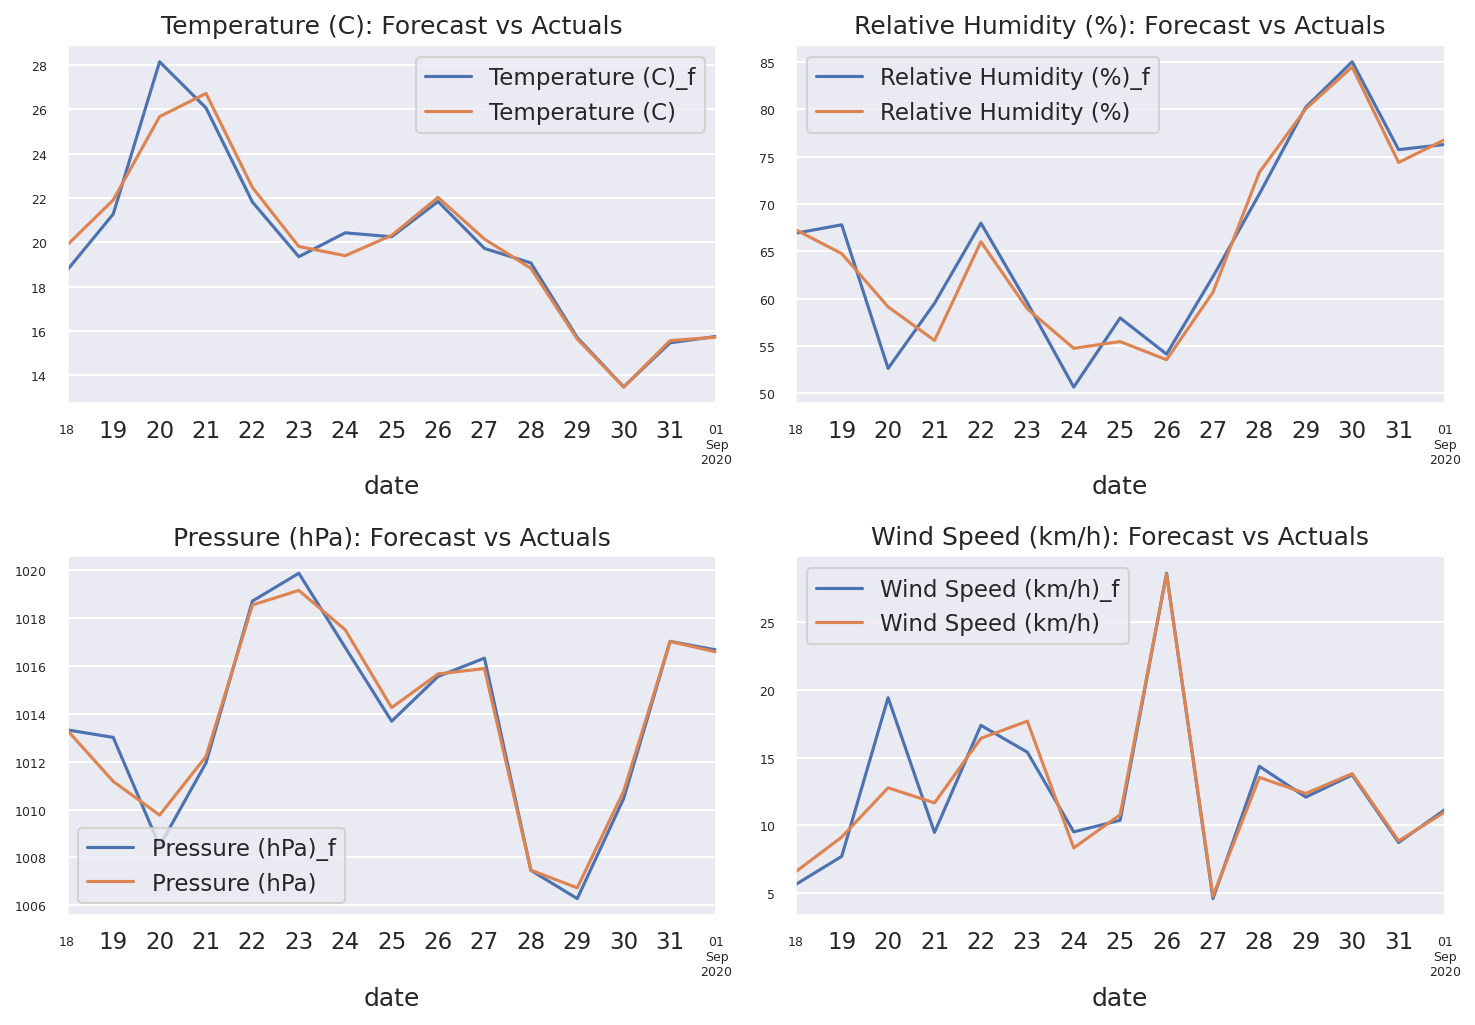

In [33]:
def plot_forecasted(forecast):
    fig, axes = plt.subplots(nrows=int(math.ceil(len(df_norm.columns)/2)), ncols=2, dpi=150, figsize=(10,7))
    for i, (col,ax) in enumerate(zip(df_norm.columns, axes.flatten())):
        forecast[col+'_f'].loc[start_forecast_date:end_forecast_date].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
        origin_set[col].loc[start_forecast_date:end_forecast_date].plot(legend=True, ax=ax);
        ax.set_title(col + ": Forecast vs Actuals")
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=6)

    plt.tight_layout();
    
plot_forecasted(df_forecasted)

It seems that the predicted data is actually very close to the actual.
#### Calculating the errors
For this project I used Root mean squared error (RMSE) and Mean absolute percent error(MAPE).<br>
RMSE express average model prediction error in units of the variable of interest. It can range from 0 to ∞ . It is negatively-oriented scores, which means lower values are better.<br>
MAPE shows the percentage of the data, which is not described by the model.

In [34]:
def forecast_accuracy(forecast, actual):
    """Constructs a data frame with calculated errors"""
    features, mae, rmse, mapes = [], [], [], []
    for col in actual.columns:
        features.append(col)
        mae.append(np.mean(np.abs(forecast[col+'_f'] - actual[col])))
        rmse.append(math.sqrt(mean_squared_error(actual[col], forecast[col+'_f'] )))
        mapes.append((np.mean(np.abs(forecast[col+'_f'] - actual[col]) / \
                              np.abs( actual[col]))) * 100)
    return pd.DataFrame(data={'feature':features,'rmse':rmse, 'mape':mapes})

In [35]:
forecast_accuracy(df_forecasted, origin_set[start_forecast_date:end_forecast_date])

,feature,rmse,mape
0,Temperature (C),0.826357,2.477843
1,Relative Humidity (%),2.646718,3.312733
2,Pressure (hPa),0.684208,0.045917
3,Wind Speed (km/h),2.003716,10.198274


### Random forest regressor
Random forest regressor was chosen to compete the VAR model.
To make a forecast on weather elements I had to create additional columns to the time series. For each of the original columns I have created 10 lags containing the values from previous 10 days.This way every feature kept part of his own history. Then i let the model to chose the 12 most significant lags for the predictions as it was with the VAR model.<br>
Here  the time period of the time series was extended, because after creating the lags, there were some observations with Nan values. After their removal I ended up with a time series with the same index as VAR's time series.

In [36]:
#Get original dataset
rf_data = df_norm[start_rfe_train_data : end_forecast_date]
rf_data.head()

,Temperature (C),Relative Humidity (%),Pressure (hPa),Wind Speed (km/h)
date,,,,
2020-06-09,-0.047608,0.217977,0.001000,0.221791
2020-06-10,0.033656,0.016149,-0.000741,-0.094835
2020-06-11,0.083886,-0.145531,-0.003167,-0.389790
2020-06-12,0.110165,-0.227928,-0.002560,0.266084
2020-06-13,-0.078165,0.253428,0.005171,-0.034423


In [37]:
df_lags = rf_data.copy()
"""Creating 10 additional lags for every feature"""
for feat in rf_data.columns:
    for i in range(1,11):
        df_lags[feat + '_lag' + str(i)] = df_lags[feat].shift(i)
df_lags = df_lags.dropna()
df_lags.head()

,Temperature (C),Relative Humidity (%),Pressure (hPa),Wind Speed (km/h),Temperature (C)_lag1,Temperature (C)_lag2,Temperature (C)_lag3,Temperature (C)_lag4,Temperature (C)_lag5,Temperature (C)_lag6,...,Wind Speed (km/h)_lag1,Wind Speed (km/h)_lag2,Wind Speed (km/h)_lag3,Wind Speed (km/h)_lag4,Wind Speed (km/h)_lag5,Wind Speed (km/h)_lag6,Wind Speed (km/h)_lag7,Wind Speed (km/h)_lag8,Wind Speed (km/h)_lag9,Wind Speed (km/h)_lag10
date,,,,,,,,,,,,,,,,,,,,,
2020-06-19,0.031787,-0.052047,0.003521,-0.219012,0.015815,-0.100540,-0.005337,0.042487,-0.027042,-0.078165,...,-0.055732,0.172466,-0.423658,-0.240498,0.393691,-0.034423,0.266084,-0.389790,-0.094835,0.221791
2020-06-20,0.050725,-0.055570,0.002730,-0.368590,0.031787,0.015815,-0.100540,-0.005337,0.042487,-0.027042,...,-0.219012,-0.055732,0.172466,-0.423658,-0.240498,0.393691,-0.034423,0.266084,-0.389790,-0.094835
2020-06-21,0.073886,-0.034475,-0.000135,0.099507,0.050725,0.031787,0.015815,-0.100540,-0.005337,0.042487,...,-0.368590,-0.219012,-0.055732,0.172466,-0.423658,-0.240498,0.393691,-0.034423,0.266084,-0.389790
2020-06-22,0.014944,0.089416,0.002507,0.250259,0.073886,0.050725,0.031787,0.015815,-0.100540,-0.005337,...,0.099507,-0.368590,-0.219012,-0.055732,0.172466,-0.423658,-0.240498,0.393691,-0.034423,0.266084
2020-06-23,0.033656,-0.050962,-0.001340,0.134685,0.014944,0.073886,0.050725,0.031787,0.015815,-0.100540,...,0.250259,0.099507,-0.368590,-0.219012,-0.055732,0.172466,-0.423658,-0.240498,0.393691,-0.034423


Here the training and validation sets were created. They have the same time period as it was with the VAR's final data.
`GridSearchCV` was used to determine the best parameters for the model.
To save a computing time , the `param_grid` was determine after a lot of experiments.

In [38]:
#Creating the train sets
rfr_features = ['Temperature (C)', 'Relative Humidity (%)','Pressure (hPa)',
              'Wind Speed (km/h)']
X = df_lags[start_train_date:end_train_date].drop(rfr_features, axis=1)
y = df_lags[start_train_date:end_train_date][rfr_features]

In [39]:
#Initializing and fitting the GridSearchCV with the training data
param_grid = {'n_estimators': [50, 100, 200],
              'max_depth': [3, 5, 6]}
grid_clf = GridSearchCV(RandomForestRegressor(random_state = 7), param_grid, cv=5)
grid_clf.fit(X, y) 

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=7),
             param_grid={'max_depth': [3, 5, 6],
                         'n_estimators': [50, 100, 200]})

In [40]:
final_regressor = grid_clf.best_estimator_
grid_clf.best_params_

{'max_depth': 5, 'n_estimators': 100}

Afterwards I used `feature importance` attribute of `Random Forest Regressor` to determine witch exactly lags should use. I let the model to choose 12 most important lags.

In [41]:
# Creating data frame with the most important feratures according to the model
f_importances = np.array(final_regressor.feature_importances_)
f_names = X.columns
f_frame = pd.DataFrame(data ={'features':f_names, 'importance':f_importances})
f_frame.sort_values(by=['importance'], ascending=False,inplace=True)
f_frame = f_frame.head(12)
f_frame

,features,importance
30,Wind Speed (km/h)_lag1,0.101786
33,Wind Speed (km/h)_lag4,0.077566
37,Wind Speed (km/h)_lag8,0.071818
0,Temperature (C)_lag1,0.069010
22,Pressure (hPa)_lag3,0.046425
25,Pressure (hPa)_lag6,0.042539
2,Temperature (C)_lag3,0.038445
39,Wind Speed (km/h)_lag10,0.034747
8,Temperature (C)_lag9,0.033922
34,Wind Speed (km/h)_lag5,0.029533


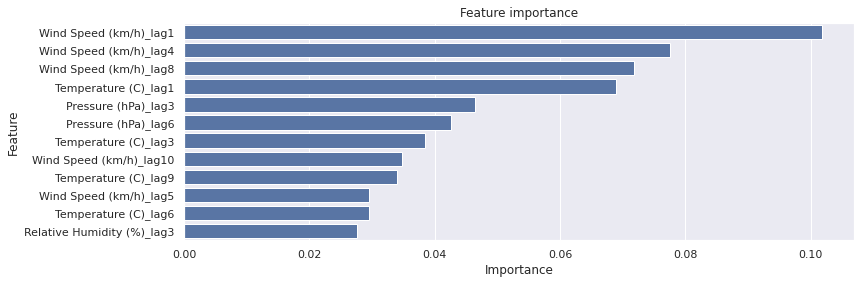

In [42]:
#Creating a plot with feature importance
plt.figure(figsize=(12,4))
chart = sns.barplot(x = f_frame.importance ,y =f_frame.features, color='b')
plt.xlabel("Importance", size=12)
plt.ylabel("Feature", size=12)
plt.title('Feature importance')
plt.show()

In [43]:
#Creating a list with the chosen lag columns.
forecast_cols = []
forecast_cols.extend(rfr_features)
forecast_cols.extend(np.array(f_frame.features))
 #Constructiing the timeseries with all the needed features
df_forecast = df_lags[forecast_cols]
df_forecast.head() 

,Temperature (C),Relative Humidity (%),Pressure (hPa),Wind Speed (km/h),Wind Speed (km/h)_lag1,Wind Speed (km/h)_lag4,Wind Speed (km/h)_lag8,Temperature (C)_lag1,Pressure (hPa)_lag3,Pressure (hPa)_lag6,Temperature (C)_lag3,Wind Speed (km/h)_lag10,Temperature (C)_lag9,Wind Speed (km/h)_lag5,Temperature (C)_lag6,Relative Humidity (%)_lag3
date,,,,,,,,,,,,,,,,
2020-06-19,0.031787,-0.052047,0.003521,-0.219012,-0.055732,-0.240498,-0.389790,0.015815,-0.001868,0.005171,-0.005337,0.221791,0.033656,0.393691,-0.078165,0.029890
2020-06-20,0.050725,-0.055570,0.002730,-0.368590,-0.219012,-0.423658,0.266084,0.031787,-0.003129,0.004427,-0.100540,-0.094835,0.083886,-0.240498,-0.027042,0.223880
2020-06-21,0.073886,-0.034475,-0.000135,0.099507,-0.368590,0.172466,-0.034423,0.050725,0.001508,0.002183,0.015815,-0.389790,0.110165,-0.423658,0.042487,-0.196049
2020-06-22,0.014944,0.089416,0.002507,0.250259,0.099507,-0.055732,0.393691,0.073886,0.003521,-0.001868,0.031787,0.266084,-0.078165,0.172466,-0.005337,-0.052047
2020-06-23,0.033656,-0.050962,-0.001340,0.134685,0.250259,-0.219012,-0.240498,0.014944,0.002730,-0.003129,0.050725,-0.034423,-0.027042,-0.055732,-0.100540,-0.055570


Lagged time series were constructed and I was able to create the training and validating sets for wanted time period.<br>
Then the transformation of the data was inverted and the forecast was displayed in a data frame.


In [44]:
#Creating datasets for testing and validating
lags_X = df_forecast.drop(rfr_features, axis = 1)
lags_y = df_forecast[rfr_features]

final_train_X = lags_X[start_train_date : end_train_date]
final_train_y = lags_y[start_train_date : end_train_date]
valid_X = lags_X[start_forecast_date : end_forecast_date]
valid_y = lags_y[start_forecast_date : end_forecast_date]
 
#Fitting training sets
final_regressor.fit(final_train_X, final_train_y)
print("R squared: {:.4f}".format(final_regressor.score(final_train_X, final_train_y)))
#Make predictions
predictions = final_regressor.predict(valid_X)
rf_residuals = predictions - valid_y
#Constructing a dataframe with the forecast
df_regr_forecast = pd.DataFrame(data = predictions, index = valid_y.index, columns = valid_y.columns )

#Reverting the transformed data;
df_regr_forecast = revert_transformation(df_regr_forecast, start_forecast_date , end_forecast_date)
df_regr_forecast.head()

R squared: 0.6368


,Temperature (C)_f,Relative Humidity (%)_f,Pressure (hPa)_f,Wind Speed (km/h)_f
date,,,,
2020-08-18,20.100421,66.885953,1013.387780,7.031088
2020-08-19,21.760210,65.483014,1011.361386,8.070219
2020-08-20,25.865222,56.980280,1009.544960,12.241265
2020-08-21,26.314784,56.138959,1013.052887,9.457041
2020-08-22,22.703197,66.227216,1018.654984,14.969870


As with the VAR model, the comparison data frame and plots for each feature were constructed to display the actuals and predicted values side by side. 

In [45]:
df_rfr_comparisson = pd.DataFrame()
for col in origin_set.columns:
    df_rfr_comparisson[col] = origin_set[col][start_forecast_date:end_forecast_date]
    df_rfr_comparisson[col+'_f'] = df_regr_forecast[col+'_f']
df_rfr_comparisson.head()

,Temperature (C),Temperature (C)_f,Relative Humidity (%),Relative Humidity (%)_f,Pressure (hPa),Pressure (hPa)_f,Wind Speed (km/h),Wind Speed (km/h)_f
date,,,,,,,,
2020-08-18,19.861780,20.100421,67.291664,66.885953,1013.33760,1013.387780,6.568682,7.031088
2020-08-19,21.908030,21.760210,64.750000,65.483014,1011.17914,1011.361386,9.145569,8.070219
2020-08-20,25.671778,25.865222,59.125000,56.980280,1009.77094,1009.544960,12.773328,12.241265
2020-08-21,26.715948,26.314784,55.583332,56.138959,1012.22070,1013.052887,11.663785,9.457041
2020-08-22,22.474280,22.703197,66.000000,66.227216,1018.54584,1018.654984,16.417137,14.969870


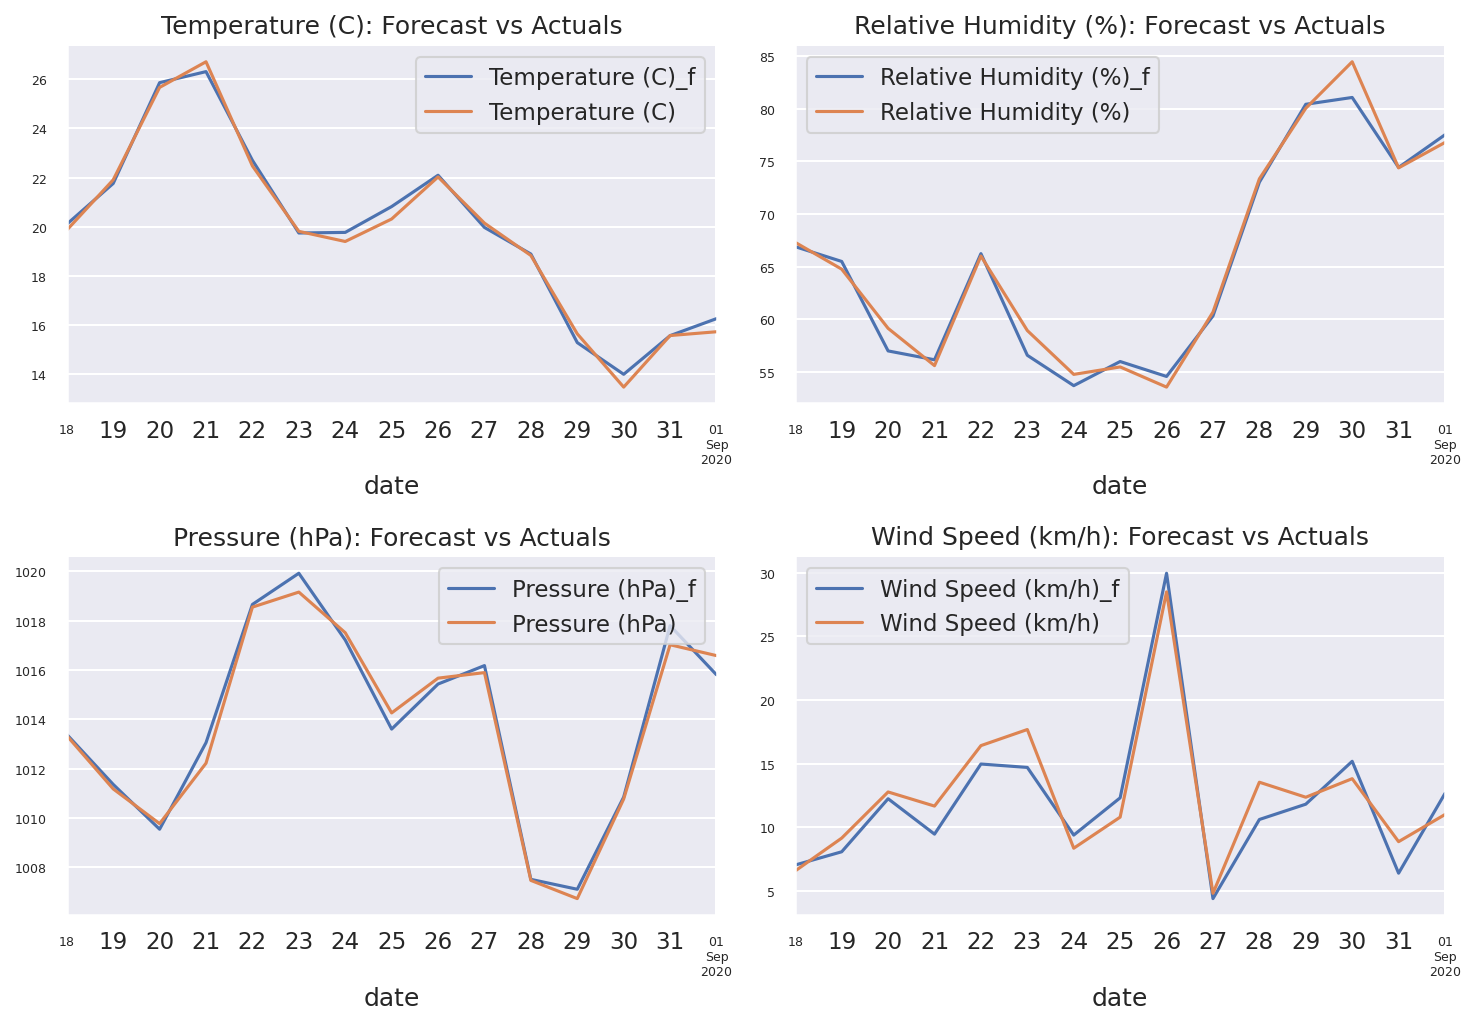

In [46]:
plot_forecasted(df_regr_forecast)

The plots with residual distribution was constructed.

In [47]:
def qq_plots(feat, df_comp):
    """Creates plots showing residual distribution"""
    with plt.rc_context():
        plt.rc("figure", figsize=(8,8))
        fig, ax = plt.subplots(2, 2)
        for i in range(2):
            for k in range(2):
                idx = i + k if i == 0 else i + k + 1
                f = features[idx]
                c_ax = ax[i][k]
                c_ax.set_title(f)
                resid = df_comp[f] - df_comp[f +'_f']
                std_resid = (resid-resid.min()) / (resid.max() - resid.min())
                sm.qqplot(resid, fit = True, line = '45', ax=c_ax)
    plt.tight_layout()
    plt.show()

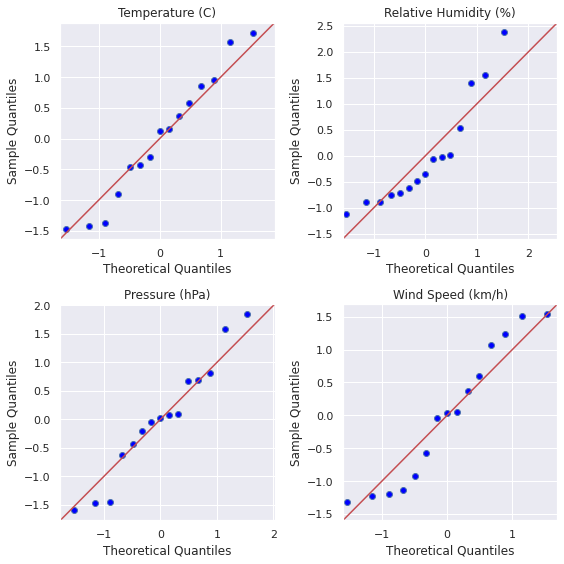

In [48]:
qq_plots(features, df_rfr_comparisson)

In [49]:
def plot_density(feat, frame):
    """Creates a plot for residual dencities for all the features"""
    with plt.rc_context():
        plt.rc("figure", figsize=(8,8))
        fig, ax = plt.subplots(2, 2)
        for i in range(2):
            for k in range(2):
                idx = i + k if i == 0 else i + k + 1
                f = feat[idx]
                resid = frame[f] - frame[f + '_f']
                sns.distplot(resid, ax = ax[i][k], axlabel = f)
    plt.tight_layout()
    plt.show()

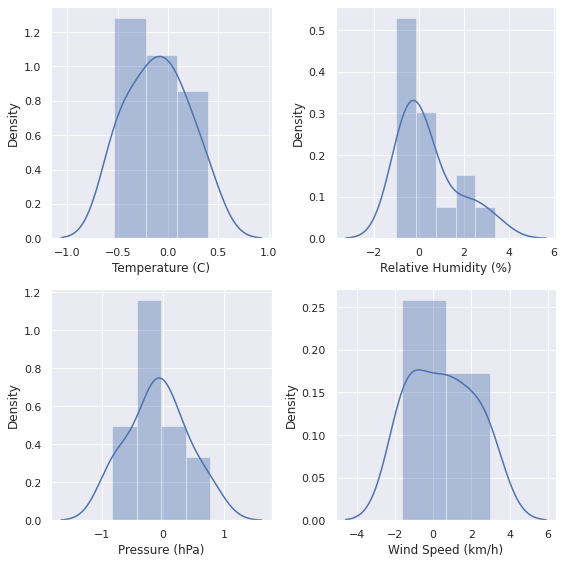

In [50]:
plot_density(features, df_rfr_comparisson)

In [51]:
for c in df_norm:
    r_mean = (df_rfr_comparisson[col] - df_rfr_comparisson[col+'_f']).mean()
    print("Residual mean for {}: {:.4f}".format(c, r_mean))

Residual mean for Temperature (C): 0.4740
Residual mean for Relative Humidity (%): 0.4740
Residual mean for Pressure (hPa): 0.4740
Residual mean for Wind Speed (km/h): 0.4740


In [52]:
out = durbin_watson(rf_residuals)
for col, val in zip(df_norm.columns, out):
    print(col, ':', round(val, 2))

Temperature (C) : 1.44
Relative Humidity (%) : 1.71
Pressure (hPa) : 1.59
Wind Speed (km/h) : 3.08


Here are shown relatively worse results than those of the VAR.The residual mean is way above 0.<br> 
Durbin-Watson statistics for Temperature is below 1.5, the wind speed is over 2.5, which is showing that there is a correlation in the residuals.

In [53]:
#Random forest regressor evaluation
forecast_accuracy(df_regr_forecast, origin_set[start_forecast_date:end_forecast_date])

,feature,rmse,mape
0,Temperature (C),0.310972,1.397548
1,Relative Humidity (%),1.317644,1.466821
2,Pressure (hPa),0.474797,0.037347
3,Wind Speed (km/h),1.690315,12.455113


### Conclusion
During my work I noticed that with a shorter data set, VAR model handles better the residuals and their distribution. On the other side, calculated RMSEs for both models are almost equal.
In terms of absolute values the forecast are very close as well.
So if it comes to short term weather forecast both models are capable of making accurate forecasts. 

#### Reference
- [Meteoblue](https://www.meteoblue.com/)
- [Scikit-Learn](https://scikit-learn.org/stable/index.html)
- [Statsmodels](https://www.statsmodels.org/stable/index.html)
- [Medium](https://medium.com)
- [Machinelearningmastery](https://machinelearningmastery.com)
- [Investopedia](https://www.investopedia.com/terms/d/durbin-watson-statistic.asp)
- [Wikipedia](https://www.wikipedia.org/)